In [1]:
! git clone https://github.com/mmeagher/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 77 (delta 17), reused 2 (delta 2), pack-reused 27 (from 1)
Receiving objects: 100% (77/77), 1.90 MiB | 50.00 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [2]:
%cd point-e/

/content/point-e


In [3]:
pip install -e .

Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-xtjwzxlf/clip_d5b04c36ae7c43e3ab2062a895c8bd95
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-xtjwzxlf/clip_d5b04c36ae7c43e3ab2062a895c8bd95
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=0bd284890c1f1b414c8023df87fae9cbc94a9c8336d0c67e9caed3fb5b91a104
  Stored in directory: /tmp/pip-ephem-wheel-cache-se4effx1/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
  Running setup.py develop for point-e


In [4]:
import torch
from tqdm.auto import tqdm

import point_e.util.point_cloud as pt

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:04<00:00, 187MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [33]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [7]:
# Create a new sampler with parameters for cleaner, more precise results
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[5.0, 0.0],        # Stronger guidance for sharper features
    model_kwargs_key_filter=('texts', ''),
    karras_steps=[128, 128],          # More steps for better quality
    s_churn=[0.5, 0],                 # Much less noise for cleaner boundaries
)

In [50]:
# Create a sampler with more organic/noisy appearance
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[2.0, 0.0],        # Less strict adherence
    model_kwargs_key_filter=('texts', ''),
    karras_steps=[64, 64],            # Standard steps
    s_churn=[5.0, 1.0],              # More randomness for organic look
)

In [51]:
# Set a prompt to condition on.
prompt = 'a couch for dreaming whose surface is shaped by the experience of joy and movement on a bicycle'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

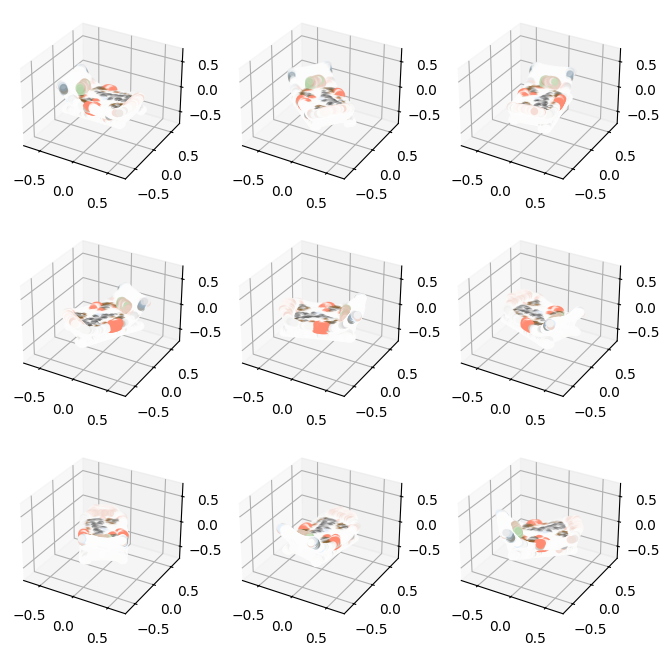

In [52]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

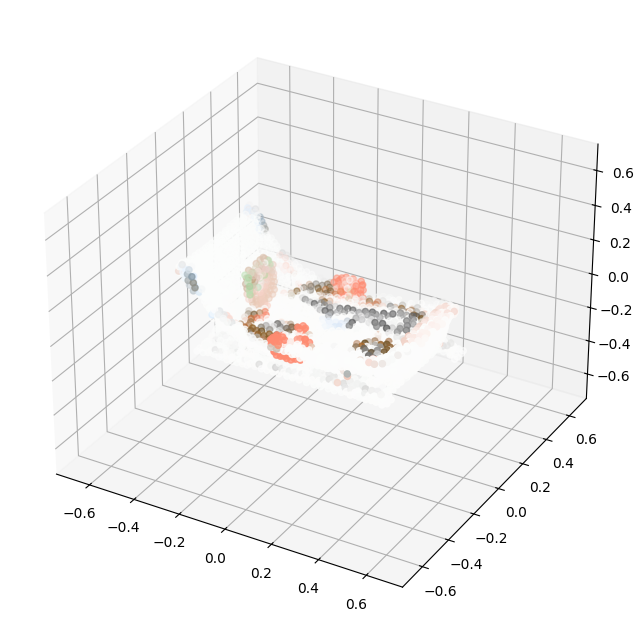

In [53]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
import numpy as np

# Add a single color to all points (e.g., gray)
num_points = len(pc.coords)
pc.channels['R'] = np.full(num_points, 0.5)  # Red channel (0.0 to 1.0)
pc.channels['G'] = np.full(num_points, 0.5)  # Green channel
pc.channels['B'] = np.full(num_points, 0.5)  # Blue channel

fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

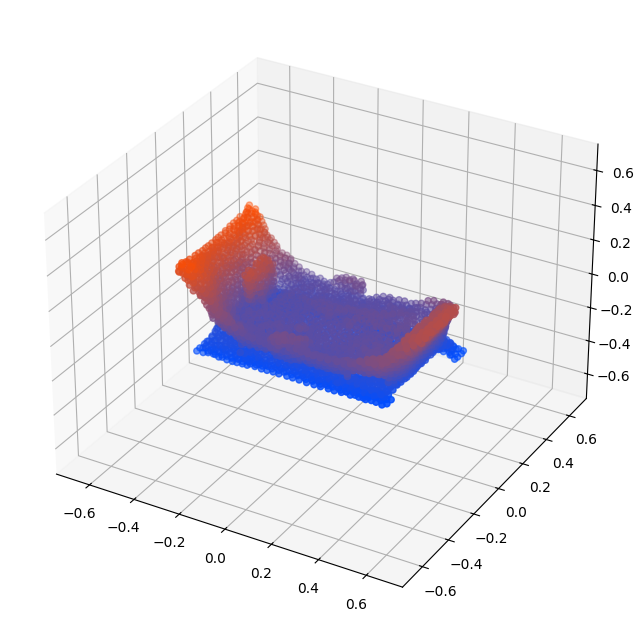

In [55]:
import numpy as np

# Color points based on their height (Z coordinate)
z_coords = pc.coords[:, 2]  # Get Z coordinates
z_min, z_max = z_coords.min(), z_coords.max()
normalized_z = (z_coords - z_min) / (z_max - z_min)  # Normalize to 0-1

# Create a gradient from blue (bottom) to red (top)
pc.channels['R'] = normalized_z
pc.channels['G'] = 0.3 * np.ones_like(normalized_z)
pc.channels['B'] = 1.0 - normalized_z

fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

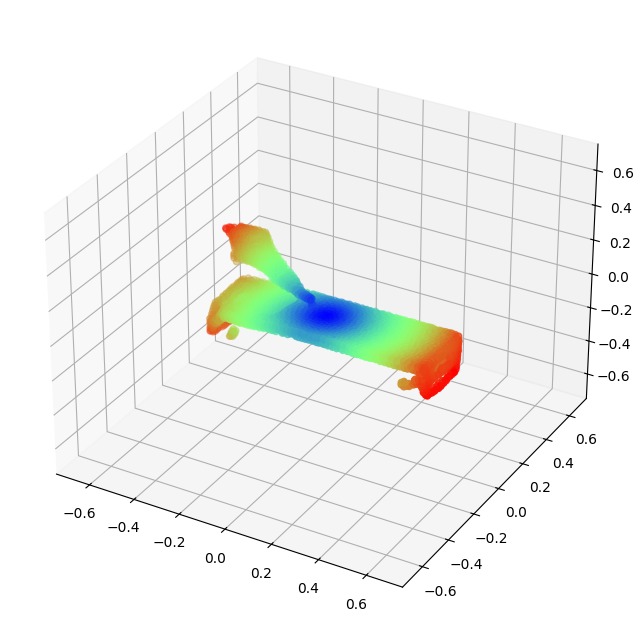

In [15]:
import numpy as np

# Color by distance from origin
distances = np.linalg.norm(pc.coords, axis=1)
normalized_dist = (distances - distances.min()) / (distances.max() - distances.min())

# Create a color map (e.g., viridis-like) - ensure all values are 0-1
pc.channels['R'] = normalized_dist
pc.channels['G'] = np.abs(np.sin(normalized_dist * np.pi))  # Use abs() to keep positive
pc.channels['B'] = 1.0 - normalized_dist

fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

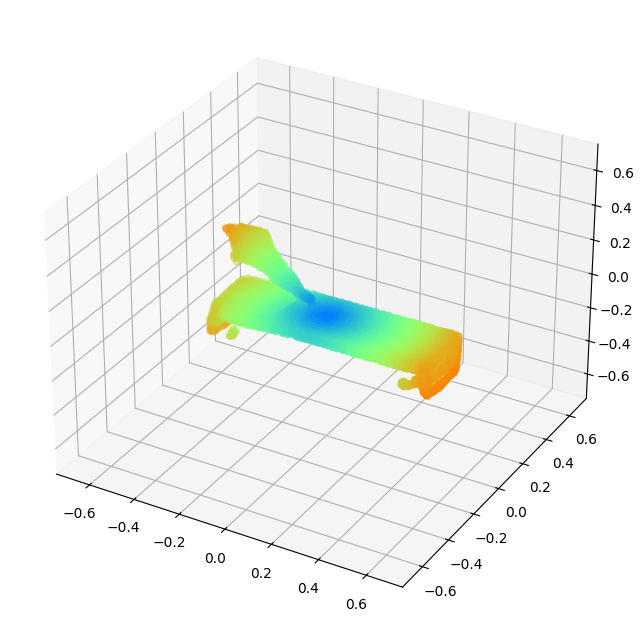

In [20]:
import numpy as np

# Color by distance from origin
distances = np.linalg.norm(pc.coords, axis=1)
normalized_dist = (distances - distances.min()) / (distances.max() - distances.min())

pc.channels['R'] = normalized_dist
pc.channels['G'] = (np.sin(normalized_dist * np.pi) + 1) / 2  # Shifted to 0-1 range
pc.channels['B'] = 1.0 - normalized_dist

fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

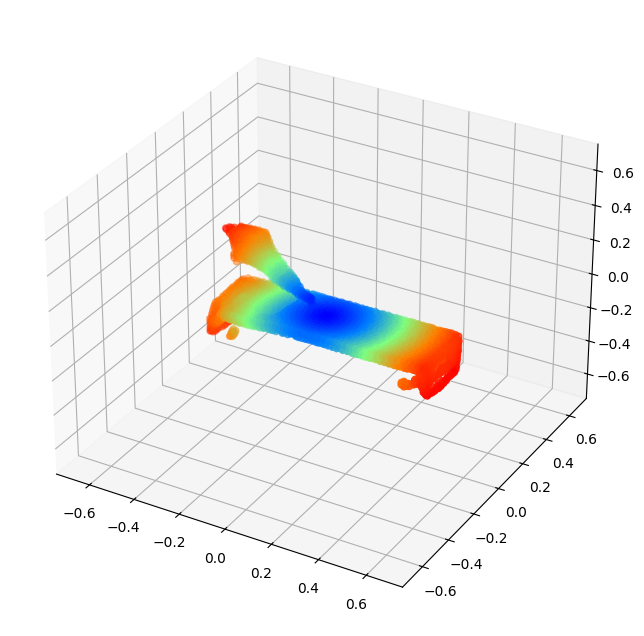

In [18]:
import numpy as np

# Color by distance from origin
distances = np.linalg.norm(pc.coords, axis=1)
normalized_dist = (distances - distances.min()) / (distances.max() - distances.min())

pc.channels['R'] = np.clip(2 * normalized_dist - 0.5, 0, 1)
pc.channels['G'] = np.clip(1 - 2 * np.abs(normalized_dist - 0.5), 0, 1)
pc.channels['B'] = np.clip(1.5 - 2 * normalized_dist, 0, 1)

fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [56]:
# Save the point cloud as a PLY file with random number
import random
random_num = random.randint(1000, 9999)
filename = f'my_pointcloud_{random_num}.ply'
with open(filename, 'wb') as f:
    pc.write_ply(f)
print(f'Point cloud saved to {filename}')

Point cloud saved to my_pointcloud_3580.ply
